In [1]:
import galsim
import tensorflow as tf
import tensorflow_hub as hub
from galaxy2galaxy import problems
%pylab inline

/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load autoencoder model
encoder = hub.Module('modules/vae_cosmos_128/encoder')
decoder = hub.Module('modules/vae_cosmos_128/decoder')

In [3]:
# Load latent flow model
sampler = hub.Module('modules/latent_flow_nvp/')

In [20]:
Modes = tf.estimator.ModeKeys
cosmos128 = problems.problem('attrs2img_cosmos128')
dset = cosmos128.dataset(Modes.TRAIN, data_dir='/data2/g2g/datasets/attrs2img_cosmos128')
dset = dset.repeat().batch(128)
batch = dset.make_one_shot_iterator().get_next()

INFO:tensorflow:Reading data files from /data2/g2g/datasets/attrs2img_cosmos128/attrs2img_cosmos128-train*
INFO:tensorflow:partition: 0 num_data_files: 80
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


In [21]:
code = encoder({'input': batch['inputs'], 'psf': batch['psf']})
samples = sampler({'flux_radius':batch['flux_radius'], 'zphot':batch['zphot'], 'mag_auto':batch['mag_auto']})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [23]:
# Assessing the distribution of codes
codes = []
params = []
codes_fake = []

for i in range(100):
    c,fr,tc = sess.run([samples, batch['mag_auto'], code])
    codes.append(tc.reshape((-1,32)))
    params.append(fr)
    codes_fake.append(c.reshape((-1,32)))
    
codes = concatenate(codes)
params = concatenate(params)
codes_fake = concatenate(codes_fake)

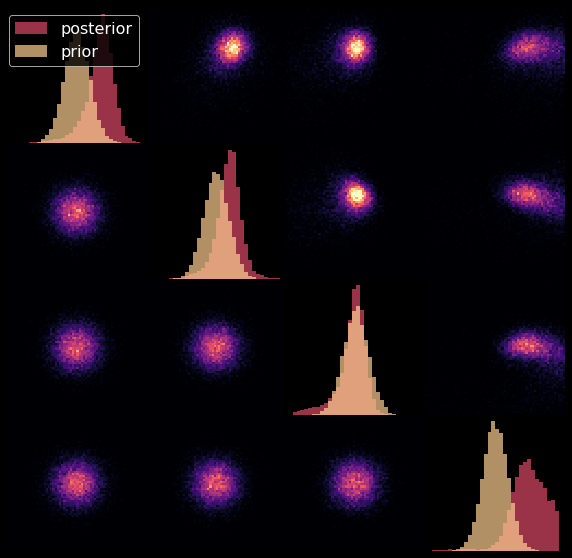

In [46]:
font = {'size'   : 16}

matplotlib.rc('font', **font)
plt.style.use('dark_background')

fig = figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        subplot(4,4,i+j*4+1)
        if i < j:
            hist2d(0*codes_fake[:,j]+randn(len(codes_fake[:,j])), 0*codes_fake[:,i]+randn(len(codes_fake[:,j])), 64, range=[[-5,5],[-5,5]],cmap='magma',vmax=80); 
            axis('off')
        elif i > j:
            sc = hist2d(codes[:,i], codes[:,j], 64, range=[[-5,5],[-5,5]],cmap='magma',vmax=80); 
            axis('off')
        else:
            hist(codes[:,i],32, range=[-5,5], alpha=0.7, label='posterior', color=plt.cm.magma(0.6));
            hist(randn(len(codes_fake[:,j])), 32, range=[-5,5], alpha=0.7, label='prior', color=plt.cm.magma(0.9));
            if i ==0:
                legend()
            axis('off')
subplots_adjust(wspace=0, hspace=0)
#savefig('Figures/Figure_LatentSpace.pdf',bbox_inches='tight')

In [14]:
len(codes)

12800

In [15]:
len(codes_fake)

12800